# Notebook 3: Extreme Values, Uncertainty, and Risk

## Introduction

In Notebook 2, we developed a rating curve from a set of discrete discharge measurements and a continuous record of water level.  At the end of the notebook, you were asked to reflect on how your confidence in the flow predicted by the rating curve changes as a function of water level.  In the near term, our confidence in the rating curve is greatest where we have the most measurements.  Recall that the shape of the rating curve is related to the geometry of the hydraulic control, and that the geometry of the river is constantly evolving.  Without continous validation of the rating curve, we should then be less confident in the rating curve over time, due to this *stream-channel geomorphic response*.  

Estimating the volume of water passing a given location during a major flood is necessary for designing infrastructure such as bridge abutments, hydraulic control structures like weirs and dams, and for designing erosion control measures.  In this notebook, we'll take a closer look at the upper end of the rating curve that governs high-magnitude flow events, where by definition we have fewer opportunities to record discrete flow measurements to robustly define a rating curve, and where measurements can be difficult to obtain accurately.  

It is often very difficult or impossible to get measurements at high flows due to safety, but also due to timing.  Hydrometric stations are often situated in remote locations, and high flow measurement requires additional planning and consideration for safe work procedures, and unique measurement approaches.  With this understanding of uncertainty in the largest *measured* flows, and recognizing that the highest stage recorded by the hydrometric station is generally substantially greater than the stage corresponding to the largest measured flows, extrapolation is unavoidable.  

Beyond extrapolation of the measured flow series at our sites of interest where *in situ* data collection may cover as little as one or two years, the estimation of peak flows for structural design extrapolates event further from measured values.  How can a 1 in 500 year flow be estimated from just two years of data measured on site? The aim of this notebook is to demonstrate the process of flood estimation, building upon the concepts developed in the previous tutorials.

### Import libraries

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/google_drive')

# move working directory to file location
%cd 'google_drive/MyDrive/Engineering_Hydrology_Notebooks/content/notebooks/Notebook_3'

import math
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from bokeh.plotting import figure, output_notebook, show
from datetime import timedelta
output_notebook()

Mounted at /content/google_drive
/content/google_drive/MyDrive/Engineering_Hydrology_Notebooks/content/notebooks/Notebook_3


## Data Imports

### Import the Daily Average Flow Data

Daily average flow data provided by the Water Survey of Canada (WSC) for the [Stave River](https://wateroffice.ec.gc.ca/report/historical_e.html?y1Max=1&y1Min=1&scale=normal&mode=Graph&stn=08MH147&dataType=Daily&parameterType=Flow&year=2016) (WSC 08MH147) is saved in `data/notebook_3_data/Stave.csv`

In [2]:
df = pd.read_csv('../../data/notebook_3_data/Stave.csv', header=1, parse_dates=['Date'], index_col='Date')
df.head()

,ID,PARAM,Value,SYM
Date,,,,
1983-02-03,08MH147,1,6.59,A
1983-02-04,08MH147,1,6.40,NaN
1983-02-05,08MH147,1,5.93,NaN
1983-02-06,08MH147,1,6.21,NaN
1983-02-07,08MH147,1,7.04,NaN


Note in the csv file the first line tells us that there are two parameters being reported: stage (water level) and flow.  When the `PARAM` column equals 1, the value corresponds to discharge, and where it equals 2 the value corresponds to stage.

The SYM column refers to data quality information.  

| SYM | Description |
|---|---|
| A | **Partial Day**: The symbol A indicates that the daily mean value of water level or streamflow was estimated despite gaps of more than 120 minutes in the data string or missing data not significant enough to warrant the use of the E symbol. |
| B | **Ice Conditions**: The symbol B indicates that the streamflow value was estimated with consideration for the presence of ice in the stream. Ice conditions alter the open water relationship between water levels and streamflow. |
| D | **Dry:** The symbol D indicates that the stream or lake is "dry" or that there is no water at the gauge. This symbol is used for water level data only. |
| E | **Estimate:** The symbol E indicates that there was no measured data available for the day or missing period, and the water level or streamflow value was estimated by an indirect method such as interpolation, extrapolation, comparison with other streams or by correlation with meteorological data. |
| R | **Revised**: The symbol R indicates that a revision, correction or addition has been made to the historical discharge database after January 1, 1989. |

(from [Water Survey of Canada](https://wateroffice.ec.gc.ca/contactus/faq_e.html#Q12))

In [3]:
# select just the flow data (PARAM == 1)
flow_df = df[df['PARAM'] == 1].copy()
flow_df.loc[:, 'year'] = flow_df.index.year
print(flow_df.head())
print('')
print("There are {} values in the Stave River daily flow series.".format(len(flow_df)))

                 ID  PARAM  Value  SYM  year
Date                                        
1983-02-03  08MH147      1   6.59    A  1983
1983-02-04  08MH147      1   6.40  NaN  1983
1983-02-05  08MH147      1   5.93  NaN  1983
1983-02-06  08MH147      1   6.21  NaN  1983
1983-02-07  08MH147      1   7.04  NaN  1983

There are 12386 values in the Stave River daily flow series.


## Plot the Data

### Plot the Daily Average Flow Series

In [5]:
# customize the tools for interacting with the bokeh plot
TOOLS="pan,wheel_zoom,reset,hover,poly_select,box_select"

#### Daily Flow Plot
daily_flow_plot = figure(width=700, height=400,
                title='Daily Average Flow at Stave River (WSC 08MH147)',
                tools=TOOLS, x_axis_type='datetime')

daily_flow_plot.line(flow_df.index, flow_df['Value'].to_numpy())
show(daily_flow_plot)

## Cumulative Frequency: The Flow Duration Curve

In order to illustrate the variability of flow in a river, it is common to map flow magnitude to cumulative frequency.  A flow duration curve presents flow magnitude from 0% to 100% exceedance, where 0 is exceeded least often, 100% is "always" exceeded (based on the sample), and 50% represents the median flow.  

Let's plot a flow duration curve for Stave River.

In [6]:
fdc_plot = figure(width=700, height=400, title='Stave River Flow Duration Curve')

pct_exceeded = np.linspace(0, 100, 200)
flow_quantiles = np.percentile(flow_df['Value'].dropna(), pct_exceeded)

fdc_plot.line(pct_exceeded[::-1], flow_quantiles)
fdc_plot.yaxis.axis_label = 'Flow [m^3/s]'
fdc_plot.xaxis.axis_label = 'Percent of Time Exceeded [%]'
show(fdc_plot)

The shape of the FDC gives some insight into the nature of the watershed.  A flatter curvature suggests less dramatic 'flashes' of rainfall-runoff response, while a steeper curve suggests more synchronization -- larger peak runoff on a unit area basis.  


## Annual Maximum Flow Series

Estimating return period floods is typically done by deriving a series corresponding to the highest flow recorded in each year.  This series is commonly referred to as the **Annual Maximum Series** (AMS).  It is necessary to use the data collected and managed by others to derive the AMS, and we will consider what this implies as we progress through the notebook.

### Create a series representing the maximum flow in each year

Derive the AMS.  Also calculate the mean and standard deviation of the series.

In [7]:
# create a series representing the annual maximum daily flow
# use the 'groupby' function and get the maximum value from each year
max_df = flow_df.loc[flow_df.groupby('year')['Value'].idxmax()].copy()

max_df['rank'] = max_df['Value'].rank(ascending=False)
max_df['month'] = max_df.index.month
max_df['count'] = flow_df.groupby('year').count()['Value'].values

In [8]:
# calculate the mean and standard deviation of the sample
mean_q, stdev_q = max_df['Value'].mean(), max_df['Value'].std()
start, end = pd.to_datetime(max_df.index.to_numpy()[0]).strftime('%Y-%m-%d'), pd.to_datetime(max_df.index.to_numpy()[-1]).strftime('%Y-%m-%d')
print('The daily average flow record goes from {} to {} (n={} years).'.format(start, end, len(max_df)))
print('Mean = {:.2f} m^3/s; Standard deviation = {:.2f} m^3/s'.format(mean_q, stdev_q))
print('Preview of the Annual Maximum Flow Series:')
max_df.head()

The daily average flow record goes from 1983-07-12 to 2016-01-28 (n=34 years).
Mean = 293.91 m^3/s; Standard deviation = 112.17 m^3/s
Preview of the Annual Maximum Flow Series:


,ID,PARAM,Value,SYM,year,rank,month,count
Date,,,,,,,,
1983-07-12,08MH147,1,382.0,NaN,1983,7.0,7,332
1984-10-08,08MH147,1,499.0,NaN,1984,2.0,10,282
1985-10-19,08MH147,1,245.0,NaN,1985,23.0,10,332
1986-02-24,08MH147,1,264.0,NaN,1986,18.0,2,365
1987-03-04,08MH147,1,262.0,NaN,1987,19.0,3,364


## Plot a histogram of annual maximum flows

If we are going to use statistical methods to estimate return period floods, it is important to consider the shape of the probability distribution, and what that implies about the dominant mechanisms driving peak runoff.  

Text(0.5, 1.0, 'Annual Maximum Flow Histogram for Stave River')

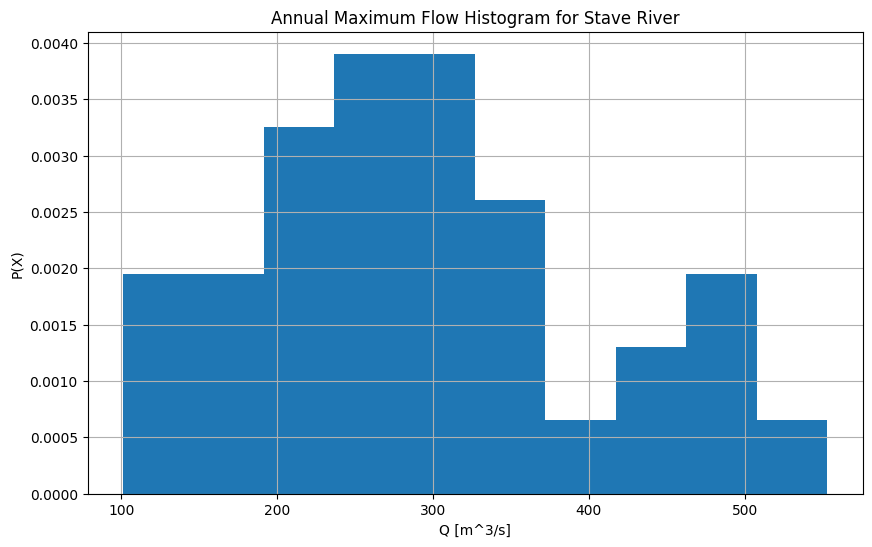

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
max_df.hist('Value', density=True, ax=ax)
ax.set_xlabel('Q [m^3/s]')
ax.set_ylabel('P(X)')
ax.set_title('Annual Maximum Flow Histogram for Stave River')

In flood frequency analysis, the shape of the sample distribution has implications for the way the parameters of a probability distribution are estimated.  The *sample* in this case is the set of annual maximum flows.  The model parameters that we will use to estimate return period floods assume certain characteristics about the data.  Namely, that values are *independent* (the annual maximum in one year does not have an observable effect on the annual maximum of other years), and *identically distributed* (values are derived from the same distribution, and are stationary over time).  In some cases these are reasonable assumptions (short planning horizon, large sample), and in others not (long planning horizon, small sample).  

Above it appears as though there are two distinct 'modes', or peaks.  Take a moment to consider what might cause multiple modes in the distribution.

### In what months does the annual maximum flow typically occur?



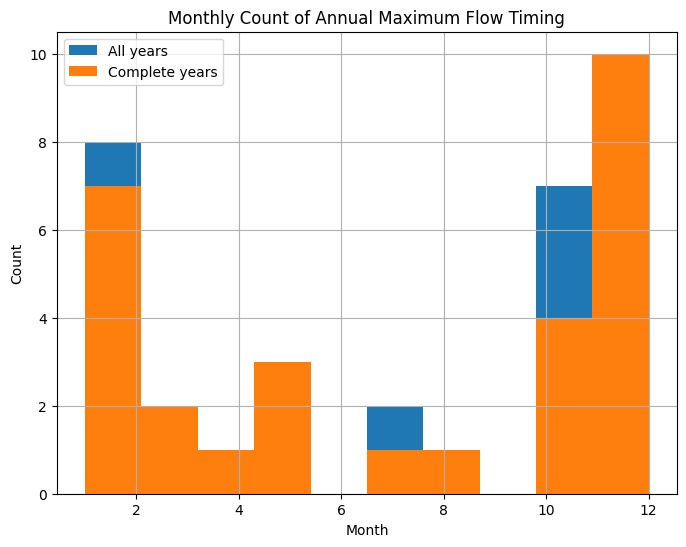

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
max_df.hist('month', ax=ax, label='All years')

complete_max_df = max_df[max_df['count'] > 360]
complete_max_df.hist('month', ax=ax,
                     label='Complete years',)
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Monthly Count of Annual Maximum Flow Timing')
ax.legend()

In the plot above, we can see that the annual maximum flow typically occurs from October to January.  Also note that the orange series has been labelled 'complete years'.  Earlier in this notebook it was pointed out that we have to rely on data collected by others.  Below we'll derive a flood frequency curve for Stave River, and in the process we'll illustrate why **quality review of data is critical**.  

## Check the record for completeness

It is often necessary to use data collected by others.  It is common for datasets to be missing documentation containing important information about quality or limitations of the data.  **Even given well documented data, it is important to do your own quality assurance**.  Below, we will use a daily average flow dataset from the Water Survey of Canada to demonstrate a few ways of validating a dataset.  This is not a manual of quality assurance, but it is used to demonstrate how to incorporate other data to do basic validation.  The general idea is that there are many other environmental signals that have mutual information with the signal of primary interest, in this case daily average streamflow at the Stave River.  For example, would you trust a large spike in runoff if nearby precipitation gauges measured zero rainfall?  Also, how do we deal with missing data?

### Completeness of Record

Find the incomplete years, and consider what we observed above regarding the times of the year the annual maximum flood is more likely to occur.  

In [11]:
df['year'] = df.index.values
max_df['count'] = flow_df.groupby('year').count()['Value'].values
print(max_df[max_df['count'] < 365])

                 ID  PARAM  Value  SYM  year  rank  month  count
Date                                                            
1983-07-12  08MH147      1  382.0  NaN  1983   7.0      7    332
1984-10-08  08MH147      1  499.0  NaN  1984   2.0     10    282
1985-10-19  08MH147      1  245.0  NaN  1985  23.0     10    332
1987-03-04  08MH147      1  262.0  NaN  1987  19.0      3    364
1989-12-03  08MH147      1  177.0  NaN  1989  30.0     12    362
1990-10-04  08MH147      1  298.0  NaN  1990  14.0     10    360
1991-08-29  08MH147      1  350.0    E  1991  10.0      8    364
1993-05-13  08MH147      1  138.0  NaN  1993  33.0      5    363
2001-01-05  08MH147      1  101.0  NaN  2001  34.0      1    173


It appears as though 1984 and 2001 are the years missing the most data.  Does this mean we should exclude these years from the AMS we use as input in the flood frequency analysis?  Are the years where only a few days of records are missing good enough?  

Even though we obtained our Stave data from WSC, the organizational body governing hydrometric data collection and standards in Canada, we still must review the data for completeness and quality.  

Looking at the printout above showing all of the years with missing days, it might be easy to justify removing 2001 from the dataset, as it is missing more than half of the year, and because we need as large a dataset as possible to buttress our statistical analysis, it is tempting to keep years with only a few missing days.  

## Reviewing the Data

Consider the possibility that the annual maximum flood is itself the reason the data is missing.  How might we determine this?

To start, we can check precipitation records at the closest climate stations.  The monthly count plot shown above suggests the annual maximum typically occurs in October to January, and on the basis that synoptic-scale precipitation events typically occur in winter, perhaps we can determine if a major precipitation event occurred during a period when there is a gap in the data.

There are no climate stations from the Meteorological Survey of Canada (MSC) in the immediate vicinity, but there are two within 100 km on either side of the Stave River basin.  

In [12]:
# whistler is equidistant to the Stave catchment in the opposite direction from the climate station in Hope.
whis_df = pd.read_csv('../../data/notebook_3_data/Whistler_348_climate.csv', header=0, index_col='Date/Time', parse_dates=True)
whis_df = whis_df[['Total Precip (mm)', 'Total Rain (mm)', 'Snow on Grnd (cm)']]
name = 'whis'
whis_df.columns = ['{}_total_precip'.format(name), '{}_total_rain'.format(name),
                   '{}_snow_on_grnd'.format(name)]

# the Laidlaw station is near Hope, BC
hope_df = pd.read_csv('../../data/notebook_3_data/Laidlaw_794_climate.csv', header=0, index_col='Date/Time', parse_dates=True)

hope_df = hope_df[['Total Precip (mm)', 'Total Rain (mm)', 'Snow on Grnd (cm)']]
name = 'hope'
hope_df.columns = ['{}_total_precip'.format(name), '{}_total_rain'.format(name),
                   '{}_snow_on_grnd'.format(name)]

# print(hope_df.head())

In [13]:
def find_data_gaps(gap_df, code):
    """
    Input a timeseries, and return a dataframe summarizing
    the start and end times of any gaps in the record.
    Note that the code assumes frequency is daily.
    """
    gap_df['Date'] = pd.to_datetime(gap_df.index.values)
    gap_df.dropna(subset=['Value'], inplace=True)
    deltas = gap_df['Date'].diff()[1:]
    # Filter diffs (here days > 1, but could be seconds, hours, etc)
    gaps = deltas[deltas > timedelta(days=1)]
    # Print results
    return gap_df, gaps

### Check flow records against precipitation records

It is common for historical records to be missing data.  Comparing flow records against precipitation records is just one way of checking to see if the gaps in the record might correspond to peak events.  Code is provided to automatically identify gaps in the record to help you see where they occur.  Note that this doesn't guarantee anything about the conditions in Stave River where we have no data, but it does provide some information with which to build a case for treating the dataset.

In [14]:
# concatenate the precipitation records with the streamflow records
conc_df = pd.concat([whis_df, hope_df, flow_df], axis=1, join='outer')
conc_df = conc_df[['Value'] + [e for e in hope_df.columns if 'hope' in e] + [e for e in whis_df.columns if 'whis' in e]]

In [15]:
print(conc_df.max())

Value                553.0
hope_total_precip    145.8
hope_total_rain      145.8
hope_snow_on_grnd     89.0
whis_total_precip     89.6
whis_total_rain       89.6
whis_snow_on_grnd    174.0
dtype: float64


In [16]:
from bokeh.models import LinearAxis, Range1d

# plot flow at Stave vs. precip at the closest climate stations
p = figure(width=900, height=400, x_axis_type='datetime')
p.line(conc_df.index, conc_df['Value'], alpha=0.8,
         legend_label='Stave Flow [m^3/s]', line_color='dodgerblue')

# plot on second y axis
p.extra_y_ranges = {'precip': Range1d(start=0, end=200)}

p.line(conc_df.index, conc_df['hope_total_rain'], alpha=0.3,
         legend_label='Hope precipitation [mm]', color='orange', y_range_name='precip')
# # p.line(conc_df_trimmed.index, conc_df_trimmed['hope_total_rain'], alpha=0.3,
# #          label='Hope precipitation [mm]', color='orange', y_range_name='precip')
p.line(conc_df.index, conc_df['whis_total_rain'], alpha=0.3,
         legend_label='Whistler precipitation [mm]', color='red', y_range_name='precip')

gap_df, gaps = find_data_gaps(conc_df, 'Stave')

# plot red bands to illustrate where there are gaps in the record
# ind = 0
xs, ys = [], []
ymin, ymax = 0, conc_df['Value'].max()

for i, g in gaps.iteritems():
    gap_start = gap_df.iloc[gap_df.index.get_loc(i) - 1]['Date']
    gap_end = gap_start + g
    xs.append([gap_start, gap_end, gap_end, gap_start])
    ys.append([ymax, ymax, ymin, ymin])

p.patches(xs, ys, fill_alpha=0.5,
        color='red',legend_label='Gap',
         line_alpha=0)

p.legend.location = 'top_left'
p.legend.click_policy = 'hide'
p.xaxis.axis_label = 'Date'#
p.yaxis.axis_label = 'Daily Average Flow [m^3/s]'
p.y_range = Range1d(0, 580)
p.add_layout(LinearAxis(y_range_name='precip', axis_label='Total Precipitation [mm]'), 'right')
show(p)

<ipython-input-16-cd6f6f206945>:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, g in gaps.iteritems():


In [17]:
print(max_df[max_df['count'] < 365])

                 ID  PARAM  Value  SYM  year  rank  month  count
Date                                                            
1983-07-12  08MH147      1  382.0  NaN  1983   7.0      7    332
1984-10-08  08MH147      1  499.0  NaN  1984   2.0     10    282
1985-10-19  08MH147      1  245.0  NaN  1985  23.0     10    332
1987-03-04  08MH147      1  262.0  NaN  1987  19.0      3    364
1989-12-03  08MH147      1  177.0  NaN  1989  30.0     12    362
1990-10-04  08MH147      1  298.0  NaN  1990  14.0     10    360
1991-08-29  08MH147      1  350.0    E  1991  10.0      8    364
1993-05-13  08MH147      1  138.0  NaN  1993  33.0      5    363
2001-01-05  08MH147      1  101.0  NaN  2001  34.0      1    173


We can use the interactive plot tools to zoom in on each of the specific years above.  The visibility of series can be toggled by clicking on the corresponding legend item.  

If we check each of the incomplete years above, we can see that some of the gaps in the Stave record correspond to large precipitation events at the precipitation stations on either side of the Stave River watershed, suggesting perhaps a gap of just a few days is related to a large event.  Consider how including a year that is missing its true largest event might affect the calculations that follow in developing the flood frequency curve.

In [18]:
# create an array of years values of the years you want to exclude
drop_years = [1984, 1989, 1991, 1993, 2001]
# here, we filter the years we don't want to include in our annual maximum series
max_df_filtered = max_df[~max_df.index.year.isin(drop_years)]

print('After reviewing the dataset, there are {} years of record in the AMS.'.format(len(max_df_filtered)))

After reviewing the dataset, there are 29 years of record in the AMS.


## Different Ways of Fitting a Probability Distribution to Measured Data

### Method of Moments

The method of moments is used to estimate the parameters of a distribution.  The parameters dictate the shape of the PDF, or the curve that approximates the histogram of measured data.  

![GEV Densities](img/GEV_densities.png)

Source: [Wikipedia](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution)

The GEV is a family of distributions, of which the first type (Type 1) is also known as the [Gumbel Distribution](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution).

The Type 1 GEV (GEV1) and Log-Pearson III are commonly used in flood frequency analysis, though we will not go further in the assumptions underlying the types of distributions here, except to say the tail behaviour (which we are interested in because it defines the flows associated with the highest return periods) is governed by the shape parameter ($\xi$), so it's important.  The GEV1 assumes $\xi = 0$

The probability of non-exceedence is given by the double exponential:

$$G(x) = 1 - e^{-e^{-y}}$$

The return period ($T$) is the inverse of $G(x)$.  The Gumbel reduced variate is given by:

$$y = -\ln{ \left( \ln{ \left(\frac{T}{T-1} \right) } \right) }$$

![Gumbel table](img/gumbel_table.png)

From above, we know the length of record is $n=29$, so:

| $n$ | $\bar{y}_n$ | $\sigma_n$ |
|---|---|---|
| 29 | 0.5353 | 1.1086 |



A tutorial for fitting a Gumbel distribution using Excel is provided [here.](https://serc.carleton.edu/hydromodules/steps/166250.html)

In [19]:
def gumbel_formula(t, ybar_n, xbar, sigma_n, sigma):
    """
    Return an estimated flood quantile based on the Gumbel formula.
    The parameters are
    described above in Table A-8.
    Inputs are:
        t: return period (years)
        ybar_n: gumbel variate (from Table provided),
        xbar: sample mean,
        sigma_n: Gumbel standard deviation (from Table provided),
        sigma: sample standard deviation
    Returns: flow corresponding to return period t
    """
    y = -np.log(np.log(t / (t - 1)))
    return  xbar + ((y - ybar_n)/sigma_n) * sigma

# define the return periods you want to calculate flows for and their associated probabilities
tr = [2.3, 5, 10, 20, 50, 100, 200, 500]
pr = [1/t for t in tr]

# Apply the gumbel formula to the selected return periods to estimate return period flood.
# Look at the format of the inputs to figure out what to replace #value1 and #value2
# below with

# q_gumbel = [gumbel_formula(t, #value1, mean_q, #value2, stdev_q) for t in tr]
mean_q, stdev_q = max_df['Value'].mean(), max_df['Value'].std()
q_gumbel_alldata = [gumbel_formula(t, 0.5353, mean_q, 1.1086, stdev_q) for t in tr]
# repeat for the filtered dataset
mean1_q, stdev1_q = max_df_filtered['Value'].mean(), max_df_filtered['Value'].std()
q_gumbel_filtered = [gumbel_formula(t, 0.5396, mean_q, 1.1255, stdev_q) for t in tr]


### Plot the results against the measured data

The appropriate method of fitting a probability distribution to measured data has been argued for decades.

In the case of Stave River, we have 34 years of record.  It's intuitive to think that the highest flow measured in that time has a probability of $\frac{1}{34}$, and a return period of 34 years, but this is incorrect.  Various adjustments to the way in which probabilities are assigned have been proposed over the decades (reference). These adjustments are referred to as *plotting positions*, and their aim is to apply a transformation to the measured data such that the data form a straight line.  If the data fall on the line exactly, the plotting position is said to be unbiased.  

A general plotting position formula is as follows:

$$\frac{1}{T} = P = \frac{m - a}{n + 1 - 2a}$$

Where $m$ is the rank (largest value = 1), $n$ is the sample size (number of years), and $a$ is some empirical value.  

The table below shows something of a history of plotting positions (from Cunnane, 1977):

| Source | Value of $a$ |
|---|---|
| Hazen (1914) | 0.5 |
| California dept. of Public Works (1923) | $\frac{(i-1)}{N}$, $\frac{i}{N}$ |
| Weibull (1939) | 0 |
| Beard (1943), Gumbel (1943), Kimball (1946) | 0.31 |
| Blom (1958) | $\frac{3}{8}$ |
| Tukey (1962) |  $\frac{1}{3}$ |
| Gringorten (1963) | 0.44 |

In [20]:
# first, we need to sort the measured data by rank
# and calculate probabilities associated with the measured data.
# The largest flood value should have rank 1
max_df = max_df.sort_values('rank')

# calculate the probabilty P and return period Tr
max_df['P'] = max_df['rank'] / (len(max_df) + 1)
max_df['Tr'] = [1/e for e in max_df['P']]

In [21]:
def plotting_position(m, a, n):
    """
    Return an adjusted plotting position (probability)
    based on the rank m, the plotting position a, and the length of record n.
    """
    return (m - a) / (n + 1 - 2 * a)

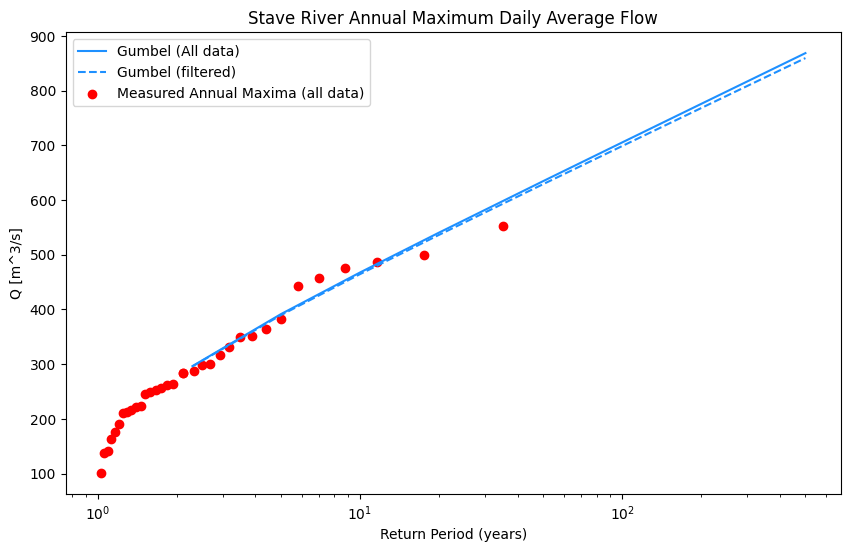

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(tr, q_gumbel_alldata, label="Gumbel (All data)",
        color='dodgerblue')
plt.plot(tr, q_gumbel_filtered, label="Gumbel (filtered)",
        color='dodgerblue', linestyle='--')
plt.scatter(max_df['Tr'], max_df['Value'],
            label='Measured Annual Maxima (all data)', c='red')

ax.set_title('Stave River Annual Maximum Daily Average Flow')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Q [m^3/s]')
# ax.set_xlim(0,200)
plt.xscale('log')
ax.legend()

## Log Pearson III Distribution

A distribution commonly used for estimating return period floods in BC is the Log-Pearson III distribution.  Here we will plot it against the GEV1 previously developed, and we'll take a look at the effects of our data review, where we'll plot both the GEV and LP3 using the entire dataset (without excluding any years) as well as a filtered dataset where we remove years where there is some likelihood the annual peak was missing from the record.

In [23]:
def calculate_LP3(values, Tr):
    """
    Fit a log-Pearson III distribution to a sample of extreme values
    given a desired set of return periods (Tr).
    """
    q_skew = st.skew(values)
    log_skew = st.skew(np.log10(values))

    # calculate the CDF
    z = pd.Series([st.norm.ppf(1-(1/return_p)) if return_p != 1 else st.norm.ppf(1-(1/return_p + 0.1)) for return_p in tr])
    lp3 = 2 / log_skew * (np.power((z - log_skew/6)*log_skew/6 + 1, 3)-1)
    lp3_model = np.power(10, np.mean(np.log10(values)) + lp3 * np.std(np.log10(values)))
    return lp3_model

In [24]:
# now set up the filtered AMS series to calculate the LP3 distribution
max_df_filtered = max_df_filtered.sort_values('rank')

# calculate the probabilty P and return period Tr
max_df_filtered['P'] = max_df_filtered['rank'] / (len(max_df_filtered) + 1)
max_df_filtered['Tr'] = [1/e for e in max_df_filtered['P']]

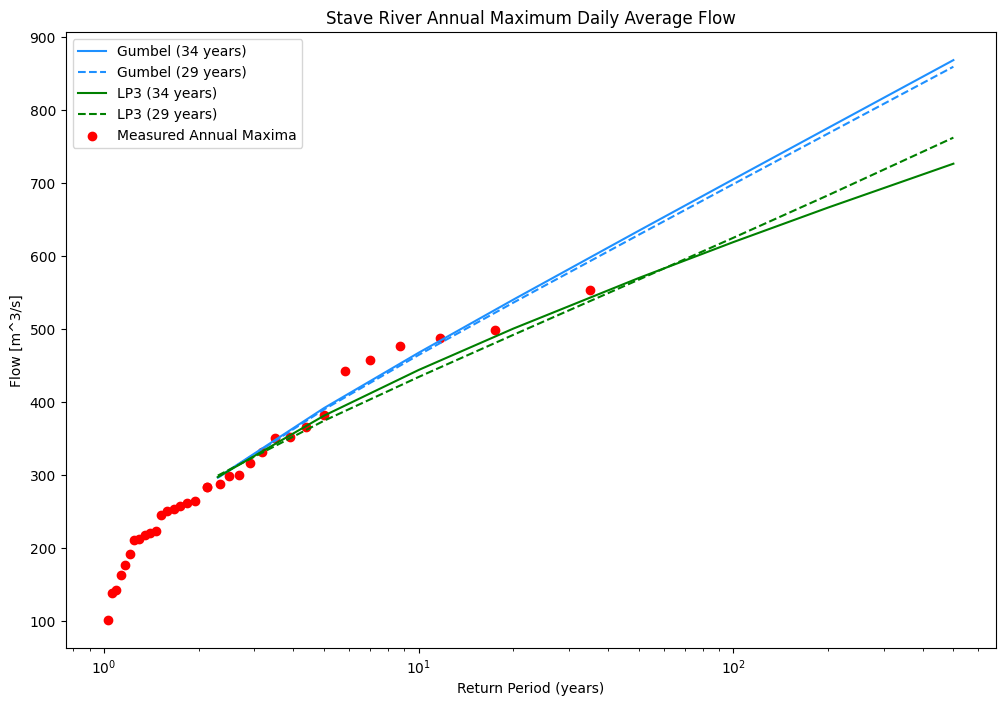

In [25]:
lp3_model = calculate_LP3(max_df['Value'], tr).to_numpy()
lp3_model_filtered = calculate_LP3(max_df_filtered['Value'], tr).to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(12,8))

plt.plot(tr, q_gumbel_alldata, label="Gumbel (34 years)", color='dodgerblue')
plt.plot(tr, q_gumbel_filtered, label="Gumbel (29 years)",
        color='dodgerblue', linestyle='--')
plt.plot(tr, lp3_model, label="LP3 (34 years)", color='green')
plt.plot(tr, lp3_model_filtered, label="LP3 (29 years)", color='green',
         linestyle='--')

plt.scatter(max_df['Tr'].to_numpy(), max_df['Value'].to_numpy(),
            label='Measured Annual Maxima', c='red')

ax.set_title('Stave River Annual Maximum Daily Average Flow')
ax.set_xlabel('Return Period (years)')
ax.set_ylabel('Flow [m^3/s]')
plt.xscale('log')
ax.legend()
plt.show()

## Risk and Uncertainty in Design

It is often the case that engineers are asked to extrapolate well beyond the range of measured data.

## Additional Considerations regarding Distribution Selection

[Bulletin 17B](https://water.usgs.gov/osw/bulletin17b/dl_flow.pdf) of the USDOE Hydrology Subcommittee of the Water Resources Council recommends the Log-Pearson Type III as the distribution for defining annual flood series.  Consider what Bulletin 17B says about sample size and extrapolation.  

The annual maximum flood events are assumed to be **independent and identically distributed (IID).**

Parts D and E (pg 7 in Bulletin 17B) discuss **mixed populations** and **measurement error**, respectively. These will be addressed sequentially.

### Mixed Populations

Here, we'll briefly revisit the histogram of annual maximum flows we saw near the beginning of this notebook.  

The mechanisms driving flood events may not be homogeneous.  For instance, the annual maximum flow may be due to snowmelt, precipitation, or a combination of the two. Recall from above (and please forgive my bad sketch of a PDF):

![Bimodal Distribution](img/bimodal_diagram.png)

How might we check if there is a clear distinction between annual floods derived from different types of event?  High flows generated by snowmelt and those generated by early winter ['pineapple express'](https://oceanservice.noaa.gov/facts/pineapple-express.html) precipitation events are unique, and are likely the reason the probability distribution of the AMS at Stave River shows a bimodal distribution, however **the sample size is small, so the shape of the distribution could also be due to sampling variability**.

What can we check to understand the processes which drive the largest magnitude runoff (flow) events?

* Check time of year
* Compare precipitation and snow values to peak events
* Look at temperature records

There is a [large body of literature](https://scholar.google.ca/scholar?q=mixed+modes+in+flood+frequency+analysis%27&hl=en&as_sdt=0&as_vis=1&oi=scholart) investigating the treatment of mixed modes in flood frequency analysis.

### Measurement Error & Sensitivity

In the introduction, we laid out the extent to which we rely on extrapolation in estimating return period flows.  This question is analogous to the assumption that the error in measurement is a random variable following some distribution.  Considering this random error exists in our measurements, what happens to the LP3 fit if we change any of the peak values by some amount?  

## Question for Reflection

Recall the discussion in the previous notebooks concerning extrapolation.  Return periods in the range of 100 and 200 years are commonly used for input design parameters in hydraulic structures, and ultimately the design values reflect a tradeoff between risk (environmental, financial, worker safety) and construction costs.  

Provide a brief discussion (500 words maximum) about the uncertainty introduced at various levels in deriving the estimate of the 100 year return period for Stave River.  Consider the difference (in this case) in the estimated 100 year return period flow based on using all the data vs. removing some years from the record, and compare it to the difference between the estimates generated between the GEV and LP3 distributions.  Consider how measurement uncertainty might affect the 100 year return flood estimate.